In [1]:
using Random
using SSM
using Distributions
using Plots
using StatsBase

In [2]:
Threads.nthreads()

8

In [3]:
# generate data from a "switching gaussian regression"
n = 100
K = 2

A = [0.8 0.2; 0.2 0.8]
β₁ = exp.(LinRange(-10, 0, 50)) ./ (sum(exp.(LinRange(-10, 0, 50)) * mean(diff(LinRange(-10, 0, 50)))))
β₂ = exp.(LinRange(-4, 0, 50)) ./ (sum(exp.(LinRange(-4, 0, 50)) * mean(diff(LinRange(-4, 0, 50)))))
σ²₁, σ²₂ = 1.0, 1.0;

In [4]:
R = 100

100

In [5]:
X = Array{Matrix{Float64}}(undef, R)
S = Array{Vector{Float64}}(undef, R)
Y = Array{Vector{Float64}}(undef, R);


In [6]:
for ii = 1:R

    x = cat(zeros(50), randn(n, 1), dims=1);
    XX = permutedims(hcat([x[i:i+50-1] for i in 1:n]...), (2,1))
    YY = zeros(n)
    SS = zeros(Int, n)

    for i in 1:n

        if i == 1
            SS[i] = StatsBase.sample(1:K, Weights([0.5, 0.5]))
        else
            SS[i] = StatsBase.sample(1:K, Weights(A[SS[i-1], :]))
        end

        if SS[i] == 1
            YY[i] = XX[i, :]'*β₁ + rand(Normal(0, sqrt(σ²₁)))
        elseif SS[i] == 2
            YY[i] = XX[i, :]'*β₂ + rand(Normal(0, sqrt(σ²₂)))
        end
    end

    X[ii] = XX;
    Y[ii] = YY;
    S[ii] = SS;

end

In [7]:
mean(map(S-> S[1], S))

1.51

In [8]:
model = SwitchingGaussianRegression(;K=2, λ=1e-2)

SwitchingGaussianRegression{Float64}([0.1859527601225834 0.8140472398774165; 0.9253078169202628 0.07469218307973727], RegressionEmissions[RegressionEmissions(GaussianRegression(Float64[], 0.0, true, 0.01)), RegressionEmissions(GaussianRegression(Float64[], 0.0, true, 0.01))], [0.8881131637540657, 0.11188683624593433], 2, 0.01)

In [9]:
ll = SSM.fit!(model, X, Y, 2000, 1e-6, true);

Log-Likelihood at iter 1: -137754.77381685533
Log-Likelihood at iter 2: -16034.287779681821
Log-Likelihood at iter 3: -15856.751175029427
Log-Likelihood at iter 4: -15846.728525427445
Log-Likelihood at iter 5: -15840.341870890315
Log-Likelihood at iter 6: -15835.305025195983
Log-Likelihood at iter 7: -15831.153266962421
Log-Likelihood at iter 8: -15827.62271827495
Log-Likelihood at iter 9: -15824.534685716391
Log-Likelihood at iter 10: -15821.75235356595
Log-Likelihood at iter 11: -15819.160102657377
Log-Likelihood at iter 12: -15816.65077418631
Log-Likelihood at iter 13: -15814.116591700404
Log-Likelihood at iter 14: -15811.445278217667
Log-Likelihood at iter 15: -15808.527513509414
Log-Likelihood at iter 16: -15805.28098045092
Log-Likelihood at iter 17: -15801.67577178682
Log-Likelihood at iter 18: -15797.71901439948
Log-Likelihood at iter 19: -15793.387612704504
Log-Likelihood at iter 20: -15788.555964313939
Log-Likelihood at iter 21: -15782.941281327783
Log-Likelihood at iter 22: -

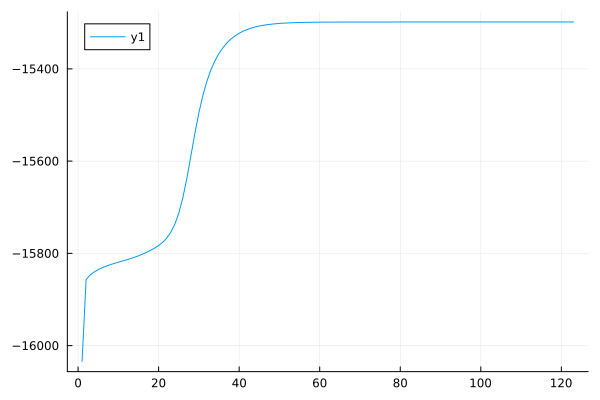

In [10]:
plot(ll[3:end])

In [11]:
model.πₖ

2-element Vector{Float64}:
 0.9999980061497507
 1.9938502572381335e-6

In [12]:
output = SSM.E_step.(Ref(model), X, Y)
γ = map(x-> x[1], output);

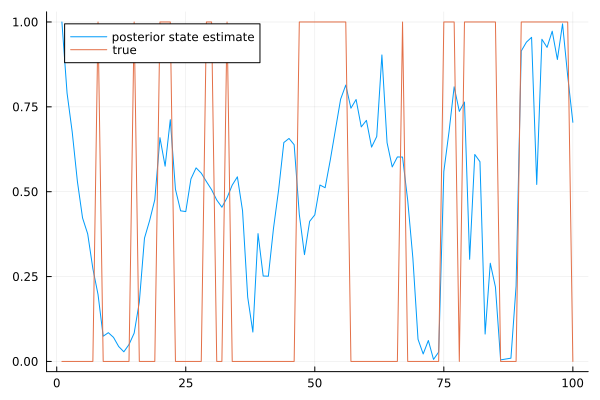

In [13]:
plot(exp.(γ[1])[:,1], label="posterior state estimate")
plot!(S[1] .- 1, label="true")

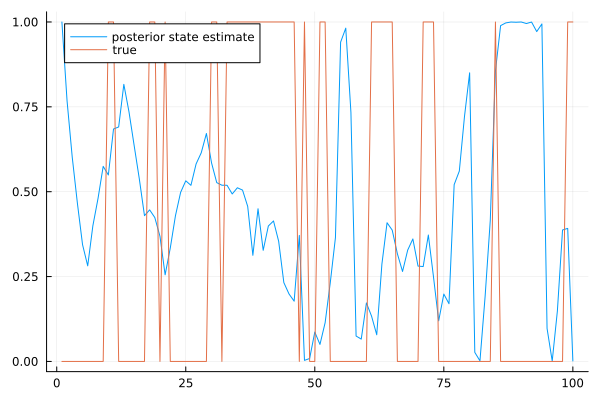

In [14]:
plot(exp.(γ[5])[:,1], label="posterior state estimate")
plot!(S[4] .- 1, label="true")

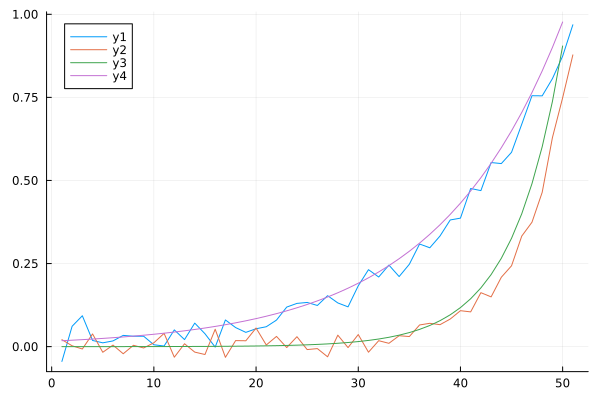

In [15]:
plot(model.B[1].regression.β)
plot!(model.B[2].regression.β)
plot!(β₁)
plot!(β₂)

In [16]:
model.A

2×2 Matrix{Float64}:
 0.768344  0.221373
 0.202666  0.7878